## SSRG Demo 
## Preprocessing Data Input Tables Site Specific RShiny Demo App
Notes:
- asdf

In [1]:
# working with data
import os
import numpy as np
import pandas as pd
import geopandas as gpd # the library that lets us read in shapefiles
import geoplot as gplt # for plotting maps

# visulizaiton
import seaborn as sns
import matplotlib.pyplot as plt

# Cleanup
from datetime import datetime
pd.set_option('display.max_columns', 999)  # How to display all columns of a Pandas DataFrame in Jupyter Notebook

In [2]:
# Setting work directory
cwd = os.getcwd()
print("current directory = " + cwd)

os.chdir("../NotEssentialData")
print("new directory = " + os.path.abspath(os.curdir))

current directory = C:\Users\rjame\Documents\WSWC Documents\WaDE Side Projects Local\20221017 Rshiny SS Demo\SSRG_Demo\bonus code
new directory = C:\Users\rjame\Documents\WSWC Documents\WaDE Side Projects Local\20221017 Rshiny SS Demo\SSRG_Demo\NotEssentialData


## Inputs

In [3]:
#Sites Input
fileInput = "Sites.csv"
dfs = pd.read_csv(fileInput)
print(len(dfs))
dfs.head(1)

11062


,SiteUUID,SiteName,SiteNativeID,WaDENameS,Longitude,Latitude,PODorPOUSite,WaDENameWS,AggregationIntervalUnitCV,VariableCV,VariableSpecificCV,HasRecords
0,CAssrg_S1,LAKE ALMANOR,ALM,Reservoir Gage,-121.173,40.218,Gage,Surface Water,Monthly,Reservoir Level,Reservoir Level_Monthly_Storage_Surface Water,Yes


## Clean Sites Data

In [4]:
# Clean input
dfs = dfs.drop_duplicates().reset_index(drop=True) # Drop Duplicate Rows
dfs = dfs.replace(np.nan, "")  # Replaces NaN values with blank.
print(len(dfs))
dfs.head(1)

11062


,SiteUUID,SiteName,SiteNativeID,WaDENameS,Longitude,Latitude,PODorPOUSite,WaDENameWS,AggregationIntervalUnitCV,VariableCV,VariableSpecificCV,HasRecords
0,CAssrg_S1,LAKE ALMANOR,ALM,Reservoir Gage,-121.173,40.218,Gage,Surface Water,Monthly,Reservoir Level,Reservoir Level_Monthly_Storage_Surface Water,Yes


In [5]:
# Fixing blank WaDENameWS
def updateWaDENameWS(Val):
    Val = str(Val).strip()
    if Val == "" or pd.isnull(Val) or Val == "":
        outString = "Unspecified"
    else:
        outString = Val
    return outString

dfs['WaDENameWS'] = dfs.apply(lambda row: updateWaDENameWS(row['WaDENameWS']), axis=1)
dfs['WaDENameWS'].unique()

array(['Surface Water', 'Groundwater', 'Unspecified'], dtype=object)

In [6]:
# Groupby SiteUUID
dfs = dfs.groupby(['SiteUUID']).agg(lambda x: ", ".join([str(elem) for elem in (list(set(x))) if elem!=""])).replace(np.nan, "").reset_index()
print(len(dfs))
dfs.head(1)

11025


,SiteUUID,SiteName,SiteNativeID,WaDENameS,Longitude,Latitude,PODorPOUSite,WaDENameWS,AggregationIntervalUnitCV,VariableCV,VariableSpecificCV,HasRecords
0,CAssrg_S1,LAKE ALMANOR,ALM,Reservoir Gage,-121.173,40.218,Gage,Surface Water,Monthly,Reservoir Level,Reservoir Level_Monthly_Storage_Surface Water,Yes


In [7]:
# count num of VariableSpecificCV after groupby

def countNumVar(Val):
    Val = list(Val.split(","))
    if Val == [""]:
        ValLen = 0
    else:
        ValLen = len(Val)
    return ValLen

dfs['CountVar'] = dfs.apply(lambda row: countNumVar(row['VariableSpecificCV']), axis=1)
dfs['CountVar'].unique()

array([1, 0, 2], dtype=int64)

In [8]:
# add State field

def createState(Val):
    Val = Val.strip()
    outString = Val[:2]
    return outString

dfs['State'] = dfs.apply(lambda row: createState(row['SiteUUID']), axis=1)
dfs['State'].unique()

array(['CA', 'CO', 'ID', 'MT', 'NE', 'NV', 'OR'], dtype=object)

In [9]:
# attach timeframe based on SiteUUID

fileInput = "start_end_Sites.csv"
dfstf = pd.read_csv(fileInput)
dfs = pd.merge(dfs, dfstf, on='SiteUUID', how='left')
print(len(dfs))
dfs.head(1)

11025


,SiteUUID,SiteName,SiteNativeID,WaDENameS,Longitude,Latitude,PODorPOUSite,WaDENameWS,AggregationIntervalUnitCV,VariableCV,VariableSpecificCV,HasRecords,CountVar,State,minTimeFrameStart,maxTimeFrameEnd
0,CAssrg_S1,LAKE ALMANOR,ALM,Reservoir Gage,-121.173,40.218,Gage,Surface Water,Monthly,Reservoir Level,Reservoir Level_Monthly_Storage_Surface Water,Yes,1,CA,1950-04-01,2022-02-01


In [10]:
# Temp Fix

# remove lat & long entries that contain a ','
dfs = dfs[dfs['Latitude'].str.contains(',') == False]
dfs = dfs[dfs['Longitude'].str.contains(',') == False]

# Ensure long is < 0 and > -125 (few ID sites out of bounds)
# Ensure lat is > 10 and < 50 (few MT sites out of bounds).
dfs['Latitude'] = pd.to_numeric(dfs['Latitude'], errors='coerce')
dfs['Longitude'] = pd.to_numeric(dfs['Longitude'], errors='coerce')
dfs = dfs[(dfs['Latitude'].astype(int) > 10) & (dfs['Latitude'].astype(int) < 50)]
dfs = dfs[(dfs['Longitude'].astype(int) < 0) & (dfs['Longitude'].astype(int) > -125)]

print(len(dfs))
dfs.head(1)

11025


,SiteUUID,SiteName,SiteNativeID,WaDENameS,Longitude,Latitude,PODorPOUSite,WaDENameWS,AggregationIntervalUnitCV,VariableCV,VariableSpecificCV,HasRecords,CountVar,State,minTimeFrameStart,maxTimeFrameEnd
0,CAssrg_S1,LAKE ALMANOR,ALM,Reservoir Gage,-121.173,40.218,Gage,Surface Water,Monthly,Reservoir Level,Reservoir Level_Monthly_Storage_Surface Water,Yes,1,CA,1950-04-01,2022-02-01


In [11]:
#Inspect output
dfs

,SiteUUID,SiteName,SiteNativeID,WaDENameS,Longitude,Latitude,PODorPOUSite,WaDENameWS,AggregationIntervalUnitCV,VariableCV,VariableSpecificCV,HasRecords,CountVar,State,minTimeFrameStart,maxTimeFrameEnd
0,CAssrg_S1,LAKE ALMANOR,ALM,Reservoir Gage,-121.173000,40.218000,Gage,Surface Water,Monthly,Reservoir Level,Reservoir Level_Monthly_Storage_Surface Water,Yes,1,CA,1950-04-01,2022-02-01
1,CAssrg_S10,BOUQUET CANYON,BQC,Reservoir Gage,-118.395314,34.586714,Gage,Surface Water,Monthly,Reservoir Level,Reservoir Level_Monthly_Storage_Surface Water,Yes,1,CA,1950-04-01,2022-02-01
2,CAssrg_S100,PLEASANT VALLEY RESERVOIR,PVR,Reservoir Gage,-118.583576,37.423578,Gage,Surface Water,Monthly,Reservoir Level,Reservoir Level_Monthly_Storage_Surface Water,Yes,1,CA,2018-10-01,2022-02-01
3,CAssrg_S101,PYRAMID,PYM,Reservoir Gage,-118.764528,34.644153,Gage,Surface Water,Monthly,Reservoir Level,Reservoir Level_Monthly_Storage_Surface Water,Yes,1,CA,1974-10-01,2022-02-01
4,CAssrg_S102,REDINGER LAKE,RDN,Reservoir Gage,-119.449000,37.145000,Gage,Surface Water,Monthly,Reservoir Level,Reservoir Level_Monthly_Storage_Surface Water,Yes,1,CA,1965-10-01,2022-02-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11020,ORssrg_S91,"CRESCENT CR AT CRESCENT LAKE NR CRESCENT, OR",14060000.0,Canal / Ditch / Stream,-121.973064,43.503043,Gage,Surface Water,Daily,Stream Gage,Stream Gage_Daily_Unspecified_Surface Water,Yes,1,OR,1912-01-01,2014-09-30
11021,ORssrg_S92,"WALKER BASIN CN NR LA PINE, OR",14062500.0,Discharge Point,-121.632785,43.534694,Gage,Unspecified,Daily,Stream Gage,Stream Gage_Daily_Unspecified_Surface Water,Yes,1,OR,1924-05-05,2011-09-30
11022,ORssrg_S93,"LITTLE DESCHUTES R NR LA PINE, OR",14063000.0,Canal / Ditch / Stream,-121.502925,43.689147,Gage,Surface Water,Daily,Stream Gage,Stream Gage_Daily_Unspecified_Surface Water,Yes,1,OR,1924-05-01,2016-09-30
11023,ORssrg_S94,"DESCHUTES R AT BENHAM FALLS NR BEND, OR",14064500.0,Canal / Ditch / Stream,-121.411542,43.930365,Gage,Surface Water,Daily,Stream Gage,Stream Gage_Daily_Unspecified_Surface Water,Yes,1,OR,1906-04-01,2016-09-30


In [12]:
dfs['WaDENameS'].unique()

array(['Reservoir Gage', 'Stream Gage', 'Canal / Ditch / Stream',
       'Reservoir', 'Well', 'Pump', 'Discharge Point', 'Reach', 'Spring',
       'Other', 'Recharge Area', 'Seep'], dtype=object)

In [13]:
dfs['WaDENameWS'].unique()

array(['Surface Water', 'Groundwater', 'Unspecified'], dtype=object)

In [14]:
dfs['VariableCV'].unique()

array(['Reservoir Level', 'Stream Gage', '',
       'Reservoir Level, Stream Gage'], dtype=object)

In [15]:
# Exporting output files.
dfs.to_excel('Sites_v2.xlsx', index=False)

## Mapping to Validate Sites

<AxesSubplot:>

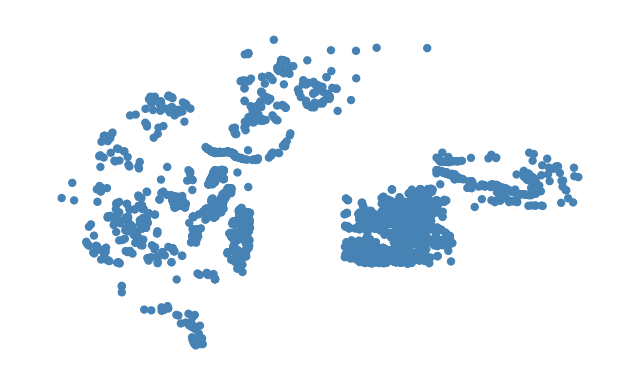

In [16]:
# map points
# convert dataframe to geodataframe
gdf_sites = gpd.GeoDataFrame(dfs, geometry=gpd.points_from_xy(dfs.Longitude.astype(float), dfs.Latitude.astype(float)), crs="EPSG:4326")
gplt.pointplot(gdf_sites)